In [ ]:
pip install tensorflow keras keras-applications keras-vggface


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define paths to your dataset
dataset_path = '/content/drive/MyDrive/test_vggface'
classes = os.listdir(dataset_path)  # Assuming class folders are names of each person

# Parameters
img_size = 224
num_classes = len(classes)

# Initialize data and labels lists
data = []
labels = []

# Load images and labels
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_size, img_size))
        data.append(img)
        labels.append(class_idx)

# Convert to numpy arrays and normalize
data = np.array(data, dtype='float32') / 255.0
labels = np.array(labels)

# One-hot encode labels
labels = to_categorical(labels, num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Multiply, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers


In [ ]:
def squeeze_excite_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]

    # Squeeze: global average pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)

    # Excitation: Dense layers
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)

    # Scale: element-wise multiplication with the original input
    se = Multiply()([input_tensor, se])

    return se


In [ ]:
# Load ResNet50 without the top layers (classification head)
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))

# Add SENet block to the output of ResNet50
x = base_model.output
x = squeeze_excite_block(x)

# Global Average Pooling and Dense layers for classification
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)  # num_classes is the number of face classes

# Build the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,230,218 (96.25 MB)

 Trainable params: 25,177,098 (96.04 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 136s 687ms/step - accuracy: 0.5577 - loss: 1.2951 - val_accuracy: 0.0987 - val_loss: 38.1137
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 69s 307ms/step - accuracy: 0.7871 - loss: 0.6023 - val_accuracy: 0.1338 - val_loss: 2.4236
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - accuracy: 0.8387 - loss: 0.5150 - val_accuracy: 0.1338 - val_loss: 2.3125
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 312ms/step - accuracy: 0.8759 - loss: 0.3861 - val_accuracy: 0.1455 - val_loss: 2.2998
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - accuracy: 0.9096 - loss: 0.2351 - val_accuracy: 0.1416 - val_loss: 2.3249
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 311ms/step - accuracy: 0.8977 - loss: 0.3184 - val_accuracy: 0.0948 - val_loss: 2.7578
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.9499 - loss: 0.1453 - val_accuracy: 0.2377 - val_loss: 2.6777
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 307ms/step - accuracy: 0.9345 - loss: 0.1861 - val_ac

In [ ]:
model.save('/content/drive/MyDrive/models_face_recognition/SENet.keras')

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.8818 - loss: 0.3467
Test Loss: 0.3479957580566406
Test Accuracy: 0.8805195093154907


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


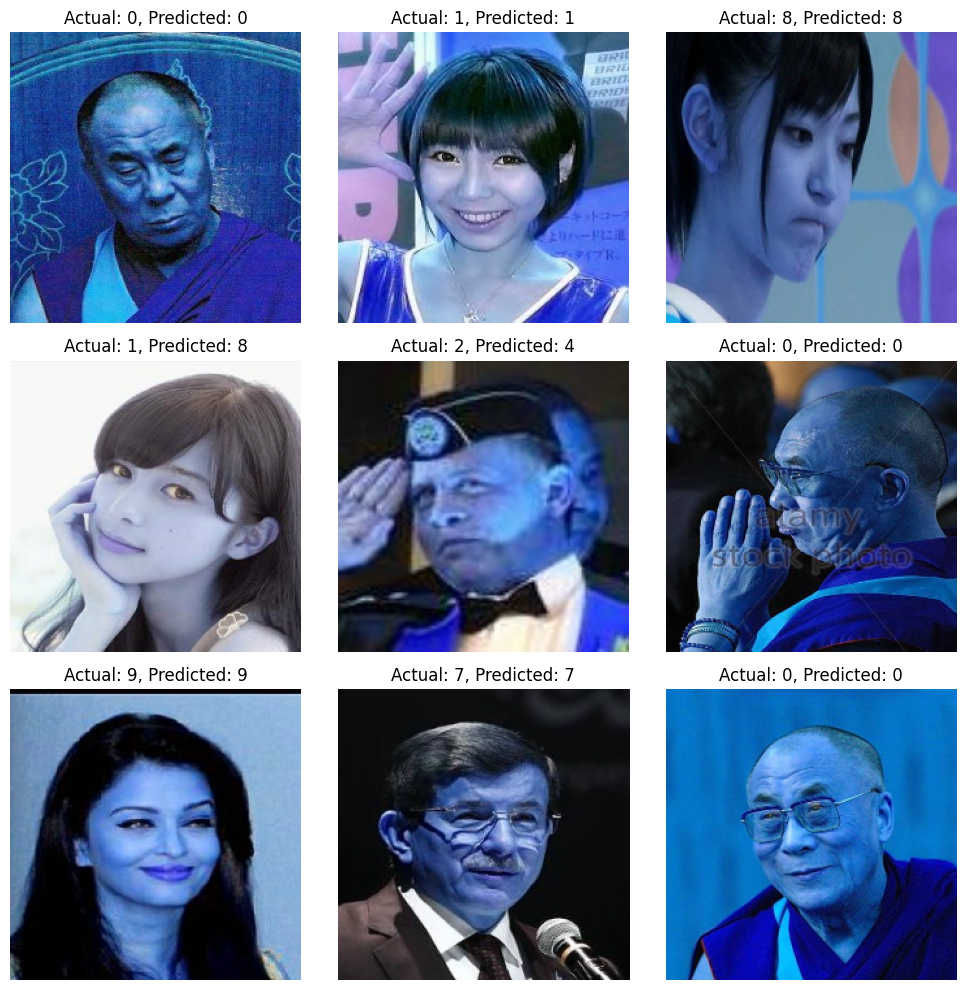

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_test is your image dataset and y_test contains the actual labels
# Assuming 'model' is your trained model

# Number of images to display
num_images = 9

# Randomly select 9 indices from the dataset
random_indices = np.random.choice(X_test.shape[0], num_images, replace=False)

# Predict the labels for the selected images
predicted_labels = model.predict(X_test[random_indices])

# Get the class labels (if you have a mapping for class indices to labels)
predicted_classes = np.argmax(predicted_labels, axis=1)  # Get the predicted class index
actual_classes = np.argmax(y_test[random_indices], axis=1)  # Get the actual class index

# Create a plot with 3x3 grid
plt.figure(figsize=(10, 10))

# Loop over the random indices and display the images
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)  # Create a subplot for each image
    plt.imshow(X_test[idx])   # Display the image
    plt.title(f"Actual: {actual_classes[i]}, Predicted: {predicted_classes[i]}")  # Show the actual and predicted labels
    plt.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()
